In [1]:
import gzip

import numpy as np
import scipy
import scipy.signal

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

In [ ]:
# run cell for interactive plots
import mpld3
mpld3.enable_notebook()

In [2]:
""" example log output is
l = "[8765c05] torque sensor:   -0.097 Nm	motor torque:    0.057 Nm	steer rate: 1728	steer angle:    0.000 rad	rear wheel angle:    0.000 rad	forward velocity:    0.000 m/s"
"""
import re
npat = r'[+-]?[0-9]*.?[0-9]+'
pattern = re.compile(
    r'\[[0-9a-z]{7}\]\storque sensor:\s+(' + npat +
    r') Nm\smotor torque:\s+(' + npat +
    r') Nm\ssteer rate:\s+(' + npat +
    r') rad/s\ssteer angle:\s+(' + npat + 
    r') rad\srear wheel angle:\s+(' + npat +
    r') rad\sforward velocity:\s+(' + npat +
    r') m/s')

In [3]:
def load_log(filename):
    """Load data from logs generated from drunlo. Returns
    a numpy record array.
    """
    datatype = np.dtype([
        ('time', '<f8'),
        ('kistler_torque', '<f8'),
        ('motor_torque', '<f8'),
        ('steer_rate', '<f8'),
        ('steer_angle', '<f8'),
        ('rear_wheel_angle', '<f8'),
        ('forward_velocity', '<f8')
    ])
    dt = 0.05 # sample period, seconds
    values = []
    
    if filename.endswith('.gz'):
        openf = lambda x: gzip.open(x, 'rt')
    else:
        openf = open
    
    with openf(filename) as f:
        for line in f:
            match = pattern.match(line)
            if match:
                # set time to zero for now
                v = (0,) + match.groups()
                values.append(v)
                
    data = np.rec.array(values, dtype=datatype)
    data.time = np.arange(0, dt*len(data.time), dt)
    return data

In [4]:
def plot_log(record, show_plot=True):
    colors = sns.color_palette('Paired', 10)
    fig, ax = plt.subplots(3, 1, figsize=(14, 10), sharex=True)
    
    ax[0].plot(record.time, record.steer_angle, color=colors[1], label='steer angle')
    ax[0].plot(record.time, 0*record.time, color='black', linewidth=1, zorder=1)
    ax[0].legend()
    ax[0].set_xlabel('time [s]')
    ax[0].set_ylabel('[rad]')
    
    ax[1].plot(record.time, record.steer_rate, color=colors[3], label='steer rate')
    ax[1].plot(record.time, 0*record.time, color='black', linewidth=1, zorder=1)
    ax[1].legend()
    ax[1].set_xlabel('time [s]')
    ax[1].set_ylabel('[rad/s]')
    
    ax[2].plot(record.time, record.kistler_torque, color=colors[5],
               alpha=0.8, label='sensor torque')
    ax[2].plot(record.time, record.motor_torque, color=colors[7],
               alpha=0.8, label='motor torque')
    ax[2].legend()
    ax[2].set_xlabel('time [s]')
    ax[2].set_ylabel('torque [N-m]')
    ax[2].plot(record.time, 0*record.time, color='black', linewidth=1, zorder=1)
    if show_plot:
        plt.show()
    return fig, ax

def display_log_plot(filename):
    vals = load_log(filename)
    fig, ax = plot_log(vals, show_plot=False)
    try:
        title = filename
        mpld3
    except NameError:
        fig.suptitle(title)
    else:
        ax[0].set_title(title)
    plt.show()

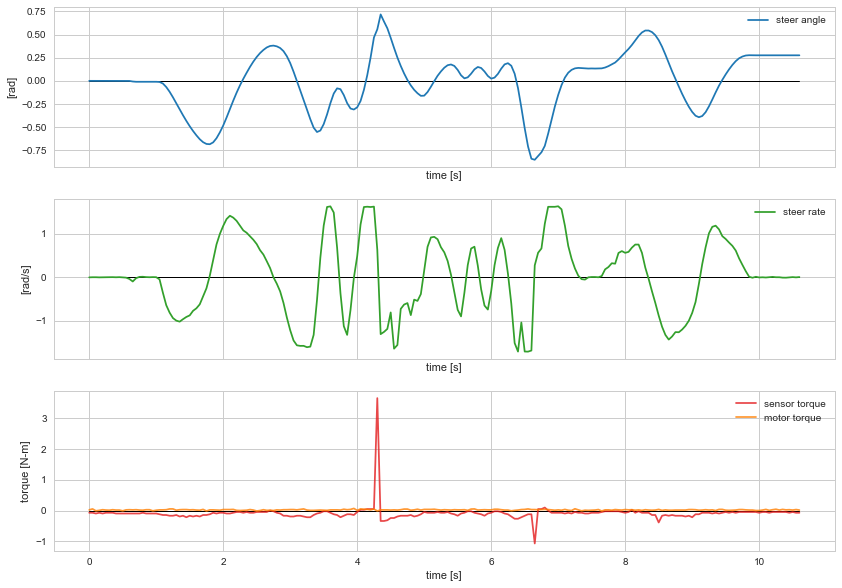

(<matplotlib.figure.Figure at 0x10cb8a5f8>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x10cc3c3c8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x10ffffb70>], dtype=object))

In [5]:
data = load_log('screenlog.0.gz')
plot_log(data)

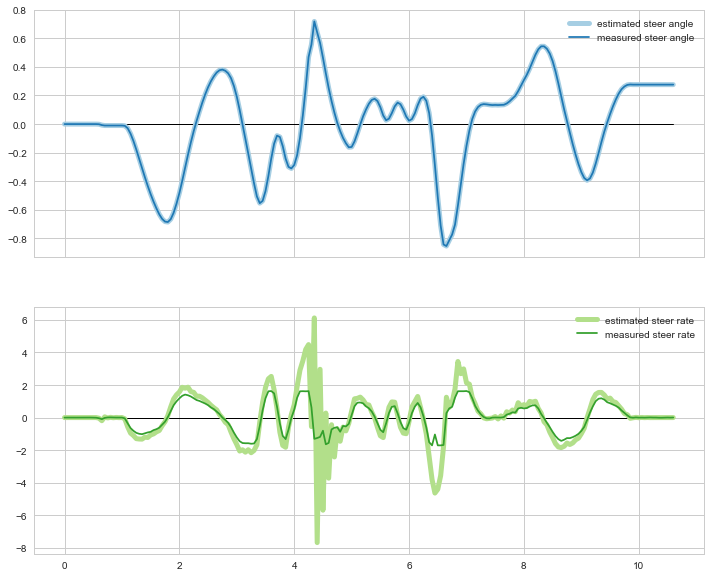

In [6]:
# estimate angular velocity and acceleration using a Kalman filter
dt = 0.05
q = 1000
Ad = np.array([
    [ 1, dt, 1/2*dt**2],
    [ 0,  1,        dt],
    [ 0,  0,         1]
])
Cd = np.array([
    [1, 0, 0]
])
Q = q * np.array([
    [1/20*dt**5, 1/8*dt**4, 1/6*dt**3],
    [ 1/8*dt**4, 1/3*dt**3, 1/2*dt**2],
    [ 1/6*dt**3, 1/2*dt**2,        dt]
])
R = np.array([
    [0.00001**2]
]) * (np.pi/180)**2

z = np.reshape(data.steer_angle, (-1, 1))
n = z.shape[0]

xhat = np.zeros((n, Ad.shape[0], 1))
xhatminus = np.zeros(xhat.shape)
P = np.zeros((n,) + Ad.shape)
Pminus = np.zeros(P.shape)
K = np.zeros((n,) + tuple(reversed(Cd.shape)))

for i in range(n):
    # time update
    # time update state
    xhatminus[i, :] = np.dot(Ad, xhat[i - 1, :])
    # time update error covariance
    Pminus[i, :] = np.dot(np.dot(Ad, P[1, :]), Ad.T) + Q
    
    # measurement update
    # measurement update kalman gain
    S = np.dot(np.dot(Cd, Pminus[i, :]), Cd.T) + R
    K[i, :] = np.linalg.lstsq(S, np.dot(Cd, Pminus[i, :].T))[0].T
    # measurement update state
    xhat[i, :] = (xhatminus[i, :] + 
                  np.dot(K[i, :], (z[i, :] - np.dot(Cd, xhatminus[i, :]))))
    P[i, :] = np.dot(np.eye(Ad.shape[0]) - np.dot(K[i, :], Cd), Pminus[i, :])
    
t = np.arange(0, dt*z.shape[0], dt)

# plot estimated steer angle vs measured steer angle
colors = sns.color_palette('Paired', 6)
fig, ax = plt.subplots(2, 1, figsize=(12, 10), sharex=True)
ax[0].plot(t, xhat[:, 0],
           color=colors[0], linewidth=5, label='estimated steer angle')
ax[0].plot(data.time, data.steer_angle,
           color=colors[1], label='measured steer angle')
ax[0].plot(t, 0*t, color='black', linewidth=1, zorder=1)
ax[1].plot(t, xhat[:, 1],
           color=colors[2], linewidth=5, label='estimated steer rate')
ax[1].plot(data.time, data.steer_rate,
           color=colors[3], label='measured steer rate')
ax[1].plot(t, 0*t, color='black', linewidth=1, zorder=1)

ax[0].legend()
ax[1].legend()
plt.show()